In [15]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
from tensorflow import keras 
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image

In [7]:
dataset_path = "./utkface-new"

os.makedirs(dataset_path, exist_ok=True)

api = KaggleApi()
api.authenticate()
print("Downloading dataset...")
api.dataset_download_files('jangedoo/utkface-new', path=dataset_path, unzip=True)
print("Dataset downloaded and extracted to:", dataset_path)



Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
Dataset downloaded and extracted to: ./utkface-new


In [5]:
dataset_path = "./utkface-new/UTKFace"

files = [f for f in os.listdir(dataset_path) if f.endswith(".jpg")]
ages = []
for file in files:
    try:
        age = int(file.split("_")[0])
        ages.append(age)
    except:
        ages.append(None)

In [6]:
df = pd.DataFrame({"file_name": files, "age": ages})
df = df.dropna().reset_index(drop=True)

In [7]:
print("Total samples:", len(df))
print(df.head())

Total samples: 23708
                                file_name  age
0  100_0_0_20170112213500903.jpg.chip.jpg  100
1  100_0_0_20170112215240346.jpg.chip.jpg  100
2  100_1_0_20170110183726390.jpg.chip.jpg  100
3  100_1_0_20170112213001988.jpg.chip.jpg  100
4  100_1_0_20170112213303693.jpg.chip.jpg  100


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="file_name",
    y_col="age",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    class_mode="raw"   
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="file_name",
    y_col="age",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    class_mode="raw"
)


Found 15173 validated image filenames.
Found 3793 validated image filenames.


In [16]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False   

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1)(x)  

model = keras.Model(inputs, outputs)


In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="mae",   
    metrics=["mae"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1096s 2s/step - loss: 14.3719 - mae: 14.3719 - val_loss: 10.9344 - val_mae: 10.9344
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - loss: 10.8840 - mae: 10.8840 - val_loss: 10.2207 - val_mae: 10.2207
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - loss: 10.3893 - mae: 10.3893 - val_loss: 9.9205 - val_mae: 9.9205
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step - loss: 10.0452 - mae: 10.0452 - val_loss: 9.5761 - val_mae: 9.5761
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 1042s 2s/step - loss: 9.7954 - mae: 9.7954 - val_loss: 9.2509 - val_mae: 9.2509
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - loss: 9.6207 - mae: 9.6207 - val_loss: 9.0762 - val_mae: 9.0762
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 841s 2s/step - loss: 9.4692 - mae: 9.4692 - val_loss: 8.8423 - val_mae: 8.8423
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 877s 2s/step - loss: 9.2717 - mae: 9.2717 - val_loss: 8.7706 - val_mae: 8.7706
Epoch 9/10
475/475 ━━━━━━━━━━━━━━━

In [19]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="mae",
    metrics=["mae"]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
475/475 ━━━━━━━━━━━━━━━━━━━━ 1427s 3s/step - loss: 10.9262 - mae: 10.9262 - val_loss: 9.1991 - val_mae: 9.1991
Epoch 2/5
475/475 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - loss: 9.0261 - mae: 9.0261 - val_loss: 8.2642 - val_mae: 8.2642
Epoch 3/5
475/475 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - loss: 8.5520 - mae: 8.5520 - val_loss: 7.8593 - val_mae: 7.8593
Epoch 4/5
475/475 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - loss: 8.1075 - mae: 8.1075 - val_loss: 7.7769 - val_mae: 7.7769
Epoch 5/5
475/475 ━━━━━━━━━━━━━━━━━━━━ 1135s 2s/step - loss: 7.7890 - mae: 7.7890 - val_loss: 7.6413 - val_mae: 7.6413


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


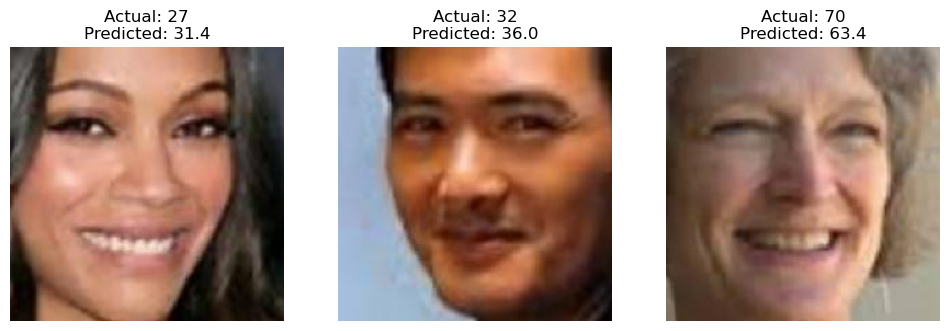

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

test_samples = test_df.sample(3)
plt.figure(figsize=(12,4))
for i, row in enumerate(test_samples.itertuples()):
    img_path = os.path.join(dataset_path, row.file_name)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)/255.
    x = np.expand_dims(x, axis=0)
    pred_age = model.predict(x)[0][0]
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"Actual: {row.age}\nPredicted: {pred_age:.1f}")
    plt.axis('off')
plt.show()